In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\Windows\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)
import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model       # model 생성
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate  # model 층 관련 모듈
from tensorflow.keras.layers import Conv2D, MaxPool2D                   # CNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D              # Max값으로 pooling해주는 함수
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop              # optimizer
import tensorflow.keras.utils as utils                                  # one-hot encoding

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet  # TensferLearning
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # 이미지 객체 생성해주는 모듈

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import random
import cv2
import zipfile
import shutil
import os
import glob

### 데이터 출처

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 데이터가 5000여개 -> 전이학습 필요
- val 데이터 수 조정 필요
- goal : 오버피팅을 줄이면서 90%이상의 정확도를 가지는 아키텍쳐 구현

CV(Computer Vision)
- Classification
    - CNN, TL(Transform Learning)
- Detection(객체탐지)
    - R-CNN, YOLO, SSD
- Segmentation
    - Unet, FCN

# Project-1

### 경로 설정

In [2]:
ROOT_DIR = "content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "chest_xray")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VAL_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")

### 데이터 가져오기

In [ ]:
#### Colab ####
from google.colab import drive

ROOT_DIR = "/content/"

drive.mount("/content/gdrive")
shutil.copy(os.path.join("/content/gdrive/MyDrive/Colab_Notebooks/", "chest_xray.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "chest_xray.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [4]:
#### PC ####
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    
with zipfile.ZipFile(os.path.join(ROOT_DIR, "chest_xray.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

### 정답 및 전체 데이터 수 확인

In [7]:
#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print("TRAIN")
print(train_file_list)
for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print("TEST")
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))
    
print("========================================================================")

#### 검증용 데이터 수 ####
val_file_list = os.listdir(VAL_DATA_ROOT_DIR)
print("VALIDATION")
print(val_file_list)
for i in range(len(val_file_list)):
    print(val_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(VAL_DATA_ROOT_DIR, val_file_list[i]))))

TRAIN
['NORMAL', 'PNEUMONIA']
NORMAL  =>  1341
PNEUMONIA  =>  3875
TEST
['NORMAL', 'PNEUMONIA']
NORMAL  =>  234
PNEUMONIA  =>  390
VALIDATION
['NORMAL', 'PNEUMONIA']
NORMAL  =>  8
PNEUMONIA  =>  8


### Image Shape 설정

In [8]:
IMG_WIDTH = 100   # colab -> 224
IMG_HEIGHT = 100

### ImageDataGenerator을 이용해서 데이터 불러오기

In [10]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse", 
                                                     subset="training")
val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                 subset="validation")
test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")

print("===============================================================================")
print(train_generator.class_indices)
print(train_generator.num_classes)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16장의 이미지 확인

- ImageDataGenerator을 통해 전달된 이미지 출력

(32, 100, 100, 3)


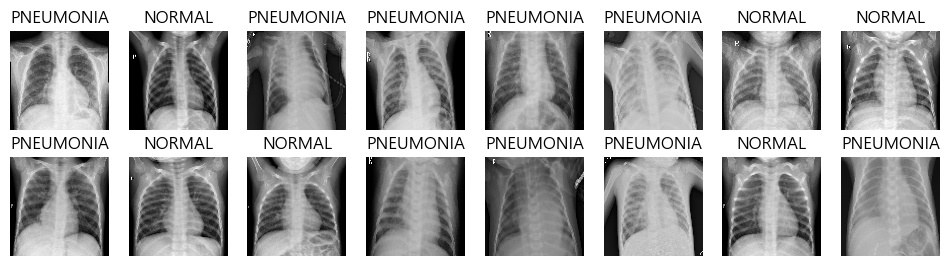

In [19]:
img, label = train_generator.next()
print(img.shape)

img = img[:16]
label = label[:16]

plt.figure(figsize=(12, 3))

for i in range(len(img)):
    plt.subplot(2, 8, i+1)
    plt.imshow(img[i])
    plt.axis("off")
    plt.title(list(train_generator.class_indices.keys())[int(label[i])])

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [21]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [24]:
model = Sequential()

model.add(pre_trained_model)

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 16)                16400     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
No

In [25]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

In [26]:
start = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=val_generator)

end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/3
131/131 [==============================] - 81s 567ms/step - loss: 0.5714 - accuracy: 0.7335 - val_loss: 0.3722 - val_accuracy: 0.8255
Epoch 2/3
131/131 [==============================] - 72s 551ms/step - loss: 0.3303 - accuracy: 0.8524 - val_loss: 0.2992 - val_accuracy: 0.8725
Epoch 3/3
131/131 [==============================] - 73s 554ms/step - loss: 0.2581 - accuracy: 0.8986 - val_loss: 0.2033 - val_accuracy: 0.9175
걸린 시간 : 0:03:47.573185


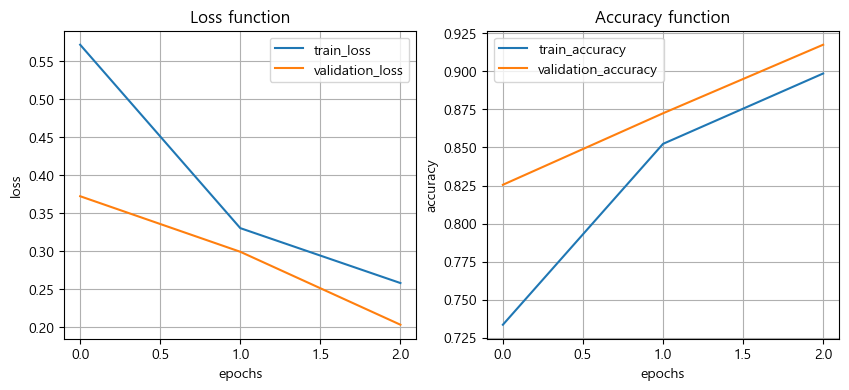

In [27]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

In [28]:
model.evaluate(test_generator)
# 점수 차이가 크다 -> 뭔가 문제가 있다!

20/20 [==============================] - 6s 286ms/step - loss: 0.7094 - accuracy: 0.7260


[0.7093565464019775, 0.7259615659713745]

In [29]:
test_simple_data_gen = ImageDataGenerator(rescale=1./255)
test_simple_generator = test_simple_data_gen.flow_from_directory(directory=VAL_DATA_ROOT_DIR, batch_size=32,
                                                                 color_mode="rgb", target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 class_mode="sparse")

Found 16 images belonging to 2 classes.


In [30]:
model.evaluate(test_simple_generator)

1/1 [==============================] - 0s 204ms/step - loss: 0.7464 - accuracy: 0.6875


[0.7464231252670288, 0.6875]

# 2. Project-2

- train과 test 데이터를 합쳐 섞은 후 재분리

In [ ]:
ROOT_DIR = "content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "chest_xray")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VAL_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")

#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print("TRAIN")
print(train_file_list)
for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print("TEST")
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))
    
print("========================================================================")

#### 검증용 데이터 수 ####
val_file_list = os.listdir(VAL_DATA_ROOT_DIR)
print("VALIDATION")
print(val_file_list)
for i in range(len(val_file_list)):
    print(val_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(VAL_DATA_ROOT_DIR, val_file_list[i]))))

### test디렉토리와 val디렉토리의 모든 파일을 train 동일 디렉토리로 MOVE

In [ ]:
test_label_name = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name)

#### test ####
for label_name in test_label_name:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 이동시킬 데이터가 들어있는 경로
    test_file_list = os.listdir(test_path)                      # 이동시킬 데이터 담아두기
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)  # 이동된 데이터를 담을 경로
    
    move_num=0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num+=1
    print(str(move_num) + " is move into " + label_name + "(test -> train)")

#### val ####
val_label_name = os.listdir(VAL_DATA_ROOT_DIR)
print(val_label_name)

for label_name in val_label_name:
    val_path = os.path.join(VAL_DATA_ROOT_DIR, label_name)    # 이동시킬 데이터가 들어있는 경로
    val_file_list = os.listdir(val_path)                      # 이동시킬 데이터 담아두기
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)  # 이동된 데이터를 담을 경로
    
    move_num=0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file), os.path.join(train_path, val_file))
        move_num+=1
    print(str(move_num) + " is move into " + label_name + "(val -> train)")

### move 완료된 train전체 데이터 수 확인

In [ ]:
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_file_list)

for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

### Shuffle 후 test와 val로 재이동

In [ ]:
MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)   # 출발 경로
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 목적 경로
    
    train_data_file_list = os.listdir(src)
    
    print("=========================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)                  # 데이터 섞어주기
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))  # 재이동시킬 데이터 수
    print("split nums =>", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), os.path.join(dst, test_data_file))
        move_num += 1
    print("move nums =>", move_num, "(train -> test)")

In [ ]:
MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)   # 출발 경로
    dst = os.path.join(VAL_DATA_ROOT_DIR, label_name)    # 목적 경로
    
    train_data_file_list = os.listdir(src)
    
    print("=========================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)                  # 데이터 섞어주기
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))  # 재이동시킬 데이터 수
    print("split nums =>", split_num)
    
    val_data_file_list = train_data_file_list[0:split_num]
    move_num = 0
    for val_data_file in val_data_file_list:
        shutil.move(os.path.join(src, val_data_file), os.path.join(dst, val_data_file))
        move_num += 1
    print("move nums =>", move_num, "(train -> val)")